# CNN para clasificación de imágenes CIFAR

In [1]:
# Importamos librerías
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import os

from tensorflow.python.eager import context

_ = tf.Variable([1])


In [2]:
context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

El dataset CIFAR contiene, ya clasificadas en 10 clases, 60000 imágenes en color.  6000 imágenes de cada clase.  El dataset ya viene dividido en 50000 imágenes de entrenamiento y 10000 de test.
Las clases no se solapan.  Son mutuamente excluyentes.

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [5]:
# Rápida mirada a los datos
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

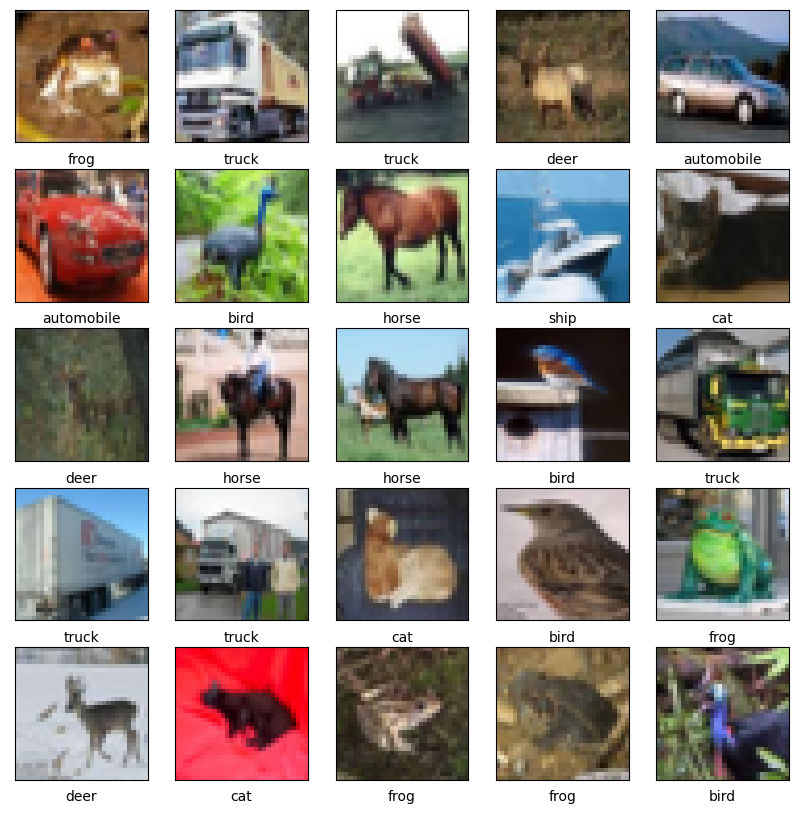

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # Las etiquetas CIFAR son arrays, por eso necesitamos un índice extra
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Creamos la CNN

In [7]:
num_filtros = 32
kernel_size = 3
pool_size = 2

In [8]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(num_filtros, kernel_size, activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D(pool_size))
model.add(layers.Conv2D(num_filtros*2, kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size))
model.add(layers.Conv2D(num_filtros*2, kernel_size, activation='relu'))

In [17]:
model.summary()  # sin añadir las capas finales de RNA

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-trai

In [18]:
# Añadimos las últimas etapas de la red
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

Vemos como pasamos de una salida de 4x4x64 neuronas a otra de 1024 neuronas

### Compilamos y entrenamos el modelo

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))


Epoch 1/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.3063 - accuracy: 0.5337 - val_loss: 1.2379 - val_accuracy: 0.5615
Epoch 2/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.1587 - accuracy: 0.5934 - val_loss: 1.1377 - val_accuracy: 0.6031
Epoch 3/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.0513 - accuracy: 0.6317 - val_loss: 1.0227 - val_accuracy: 0.6423
Epoch 4/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.9646 - accuracy: 0.6649 - val_loss: 0.9941 - val_accuracy: 0.6558
Epoch 5/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.9062 - accuracy: 0.6850 - val_loss: 1.0784 - val_accuracy: 0.6336
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.8557 - accuracy: 0.7047 - val_loss: 0.9930 - val_accuracy: 0.6748
Epoch 7/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8134 - accuracy: 0.7170 - val_loss: 1.0594 - val

### Evaluamos el modelo

313/313 - 1s - loss: 1.0208 - accuracy: 0.6794 - 600ms/epoch - 2ms/step


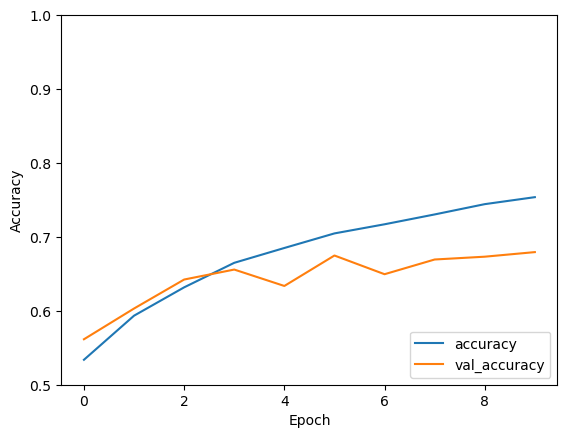

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)


### ¿Podemos mejorarlo?

In [23]:
num_filtros = 64
kernel_size = 2
pool_size = 2

In [26]:
# Añado una capa Dropout
model = models.Sequential()
model.add(layers.Conv2D(num_filtros, kernel_size, activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D(pool_size))
model.add(layers.Conv2D(num_filtros*2, kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size))
model.add(layers.Conv2D(num_filtros*2, kernel_size, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))


In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 31, 31, 64)        832       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 128)       32896     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 6, 6, 128)         65664     
                                                                 
 flatten_5 (Flatten)         (None, 4608)             

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))


Epoch 1/10
1563/1563 [==============================] - 35s 22ms/step - loss: 1.7085 - accuracy: 0.3994 - val_loss: 1.4252 - val_accuracy: 0.4907
Epoch 2/10
1563/1563 [==============================] - 31s 20ms/step - loss: 1.2517 - accuracy: 0.5551 - val_loss: 1.1598 - val_accuracy: 0.5992
Epoch 3/10
1563/1563 [==============================] - 32s 20ms/step - loss: 1.0710 - accuracy: 0.6240 - val_loss: 1.0197 - val_accuracy: 0.6416
Epoch 4/10
1563/1563 [==============================] - 32s 21ms/step - loss: 0.9596 - accuracy: 0.6658 - val_loss: 0.9959 - val_accuracy: 0.6559
Epoch 5/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.8738 - accuracy: 0.6979 - val_loss: 0.9529 - val_accuracy: 0.6822
Epoch 6/10
1563/1563 [==============================] - 32s 20ms/step - loss: 0.8007 - accuracy: 0.7218 - val_loss: 0.8894 - val_accuracy: 0.6994
Epoch 7/10
1563/1563 [==============================] - 32s 21ms/step - loss: 0.7403 - accuracy: 0.7419 - val_loss: 0.8931 -

313/313 - 2s - loss: 0.9145 - accuracy: 0.7082 - 2s/epoch - 6ms/step


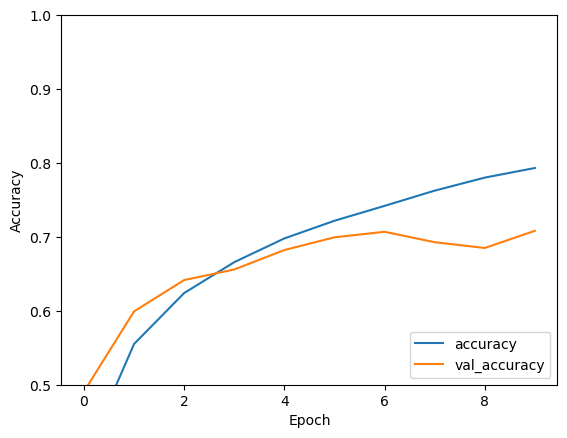

In [32]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
